In [1]:
from matplotlib import pyplot as plt
import numpy as np
import re 
import ast
from collections import defaultdict
numbers = re.compile(r'\d+(?:\.\d+)?')
import language_check

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 10em; }</style>"))

## Load output files

In [3]:
output_dir = "generation_outputs/"
with open(output_dir+"french_penalty") as f:
    french_p = f.readlines()
with open(output_dir+"spanish_penalty") as f:
    spanish_p = f.readlines()
with open(output_dir+"spanish_nopenalty") as f:
    spanish_np = f.readlines()
with open(output_dir+"french_nopenalty") as f:
    french_np = f.readlines()

## Load Processing Functions

In [4]:
def create_output_dict(outputs, num_students=15):
    output_dict = defaultdict(lambda: [])
    for i in range(0,len(outputs), 15):
        for j in range(0, 15):
            key = str(((i/15)+1)*10)
            output_dict[key].append(outputs[i+j])
    return output_dict

def analyze_outputs(output_file, difficulty, student_key, language="french"):
    with open(language+"_train") as f:
        ftrain = f.readlines()
    with open(language+"_prompts.txt") as f:
        fprompts = f.readlines()
    ftrain = "".join(ftrain)
    fprompts = "".join(fprompts)
    outputs = ast.literal_eval(output_file[-10].replace("\n","")) 
    output_dict = create_output_dict(outputs)
    in_prompt=0
    in_train=0
    novel=0
    analyzed_samples = defaultdict(lambda: [])
    for student in range(len(output_dict[difficulty])):
        if(student != student_key):
            continue
        for sample in output_dict[difficulty][student]:
            # generated output sample was seen by the student in the student state prompt
            if (sample  in fprompts and sample in ftrain):
                in_prompt +=1
                analyzed_samples["prompt"].append(sample)
            # generated output sample was seen during training
            elif (sample in ftrain and sample not in fprompts):
                in_train +=1
                analyzed_samples["train"].append(sample)
            # generated output sample was not seen during training from Duolingo data
            elif (sample not in fprompts and sample not in ftrain):
                novel +=1
                analyzed_samples["novel"].append(sample)
    likelihoods = (in_prompt/30, in_train/30, novel/30)
    return likelihoods, analyzed_samples

## Calculate Proportion of Outputs that are Novel 

In [5]:
def calculate_novelty(output_file, language, diff_type="all"):
    novelty = []
    if(diff_type=="all"):
        diff_range = ["10.0","20.0","30.0", "40.0", "50.0", "60.0", "70.0","90.0", "90.0"]
    else:
        diff_range = ["10.0"]
    for d in diff_range:
        for s in range(15):
            novelty.append(analyze_outputs(output_file, d, s, language)[0][-1])
    print("% Novel: "+str(np.average(novelty)))
    print("Total: "+str(len(novelty)*30))

### Across all difficulties

In [6]:
print("Spanish w/ Penalty")
calculate_novelty(spanish_p, language="spanish", diff_type="all")
print("French w/ Penalty")
calculate_novelty(french_p, language="french", diff_type="all")

Spanish w/ Penalty
% Novel: 0.4355555555555556
Total: 4050
French w/ Penalty
% Novel: 0.4762962962962964
Total: 4050


### Across high difficulty only

In [7]:
print("Spanish w/ Penalty")
calculate_novelty(spanish_p, language="spanish", diff_type="difficult only")
print("French w/ Penalty")
calculate_novelty(french_p, language="french", diff_type="difficult only")

Spanish w/ Penalty
% Novel: 0.6644444444444445
Total: 450
French w/ Penalty
% Novel: 0.5533333333333333
Total: 450


## Check Novelty Fluency

In [8]:
def get_all_novel(output_file, language, diff_type="all"):
    novel_phrases = []
    diff_range = ["10.0","20.0","30.0", "40.0", "50.0", "60.0", "70.0","80.0", "90.0"]
    for d in diff_range:
        for s in range(15):
            ns = analyze_outputs(output_file, d, s, language)[1]["novel"]
            for n in ns:
                novel_phrases.append(n)
    return novel_phrases

In [9]:
def get_fluency(novel_phrases):
    tool = language_check.LanguageTool('en-US')
    grammar_count = 0
    for n in novel_phrases:
        matches = tool.check(n[1:].capitalize())
        if("Grammar" in [m.category for m in matches]): #Grammar issue in sentence
            grammar_count += 1            
    print("Ungrammatical")
    print(grammar_count/len(novel_phrases))

print("Spanish w/ Penalty")
get_fluency(get_all_novel(spanish_p, "spanish"))
print("French w/ Penalty")
get_fluency(get_all_novel(french_p, "french"))

Spanish w/ Penalty
Ungrammatical
0.023424428332403793
French w/ Penalty
Ungrammatical
0.02399183256763655


## View Generation Outputs

In [10]:
#Spanish w/o Penalty Student 6
analyze_outputs(output_file=spanish_np, difficulty="10.0", language="spanish", student_key=6)[1]

defaultdict(<function __main__.analyze_outputs.<locals>.<lambda>()>,
            {'novel': [' the cuts are not big. ',
              ' the men drink a beer. ',
              ' they probably do not think me. ',
              ' the horses are not natural. ',
              ' the gallery is enormous. ',
              ' we can desk a book. ',
              ' he mixes coffee with milk. '],
             'prompt': [' from september to december '],
             'train': [' clean your room, please. ',
              ' we drink quickly. ',
              ' you can establish a restaurant. ',
              ' i want a sandwich without cheese. ',
              ' i read the newspaper. ',
              ' please sign. ',
              ' i know about that. ',
              ' we drink quickly. ',
              ' clean the mirror. ',
              ' we eat there. ',
              ' the plates are not big. ',
              ' i do not know it. ',
              ' you can create the menu. ',
              ' june

In [11]:
#Spanish w/ Penalty Student 6
analyze_outputs(output_file=spanish_p, difficulty="10.0", language="spanish", student_key=6)[1]

defaultdict(<function __main__.analyze_outputs.<locals>.<lambda>()>,
            {'train': [' you return. ',
              ' your hat is gray. ',
              ' you can create the menu. ',
              ' june starts tomorrow. ',
              ' previously on television ',
              ' you return. ',
              ' we drink quickly. ',
              ' you write letters. '],
             'novel': [' she blames us! ',
              ' clean your room or close! ',
              ' you can establish two properties. ',
              ' your house is very put- pretty! ',
              ' what does your aunt have under her shirt look like here? ',
              ' what book have they Chosen me so far? ',
              ' please sign! ',
              ' i know about that book. ',
              ' please open your bottle or newspaper? ',
              ' clean your room! ',
              ' she reads us lunchtime newspapers. ',
              ' those ducks drink water. ',
              ' october fin

In [12]:
#French w/o Penalty Student 14
analyze_outputs(output_file=french_np, difficulty="10.0", language="french", student_key=14)[1]

defaultdict(<function __main__.analyze_outputs.<locals>.<lambda>()>,
            {'prompt': [' which ones? ',
              ' you are important. ',
              ' is he chinese? ',
              ' some apples, which ones? ',
              ' where is she? ',
              ' socks ',
              ' do you want to dance with me? ',
              ' you are important. ',
              ' is he chinese? ',
              ' where is she? ',
              ' we learn. ',
              ' do you come here often? ',
              ' you are big. '],
             'novel': [' do you have three daughters? ',
              ' do you like this? ',
              ' where do the children read? ',
              ' do you speak french? '],
             'train': [' neither do we! ',
              ' the men are calm and rich. ',
              ' are we going to your place or mine? ',
              ' is he sleeping? ',
              ' you eat pork and bread. ',
              ' where do we live? ',
              ' 

In [13]:
#French w/ Penalty Student 14
analyze_outputs(output_file=french_p, difficulty="10.0", language="french", student_key=14)[1]

defaultdict(<function __main__.analyze_outputs.<locals>.<lambda>()>,
            {'novel': [' which ones do not fall victim to be sold? ',
              ' do we have chocolate or water? ',
              ' do we like to walk distance from one-to two? ',
              ' is he chinese or french? ',
              ' is he sleeping or going out time? ',
              ' some apples of your apple. ',
              ' where does she go? ',
              ' do these children have beans? ',
              ' map ofis suggests an area. ',
              ' where do we live today? ',
              " otherwise if i want to eat vegetables or fish they regionally cheese, it's meat. ",
              ' do we like to walk together or apart? ',
              ' where does he go after that jacket? ',
              ' do we have coffee here or elsewhere? ',
              ' do we have coffee together or onsocks ',
              ' is he chinese or Russian? ',
              ' do we speak soon or after tomorrow? ',
   

## Plot Generation Quality

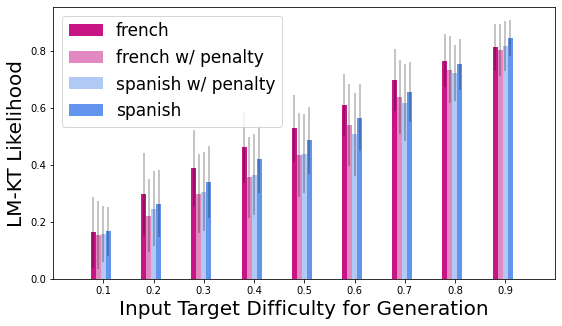

In [14]:
def plot():
    lines = [french_np, french_p, spanish_p, spanish_np]
    titles = ["french", "french w/ penalty", "spanish w/ penalty", "spanish"]
    colors = ["mediumvioletred", "mediumvioletred", "cornflowerblue", "cornflowerblue"]
    plt.figure(figsize=(9,5))
    for li in range(len(lines)):
        alpha=1.0
        if(li in [1, 2]):
            alpha=0.5
        data = [[float(numbers.findall(xi)[0]) for xi in x.split(",")] for x in lines[li][-9:]]
        x = [(d[0]/100+((li-2)/100)) for d in data]
        plt.xticks(np.array(x)-.01)
        y = [d[1] for d in data]
        std = [d[2] for d in data]
        plt.bar(x,y, yerr=std, width=.01, color=colors[li], label=titles[li], error_kw={"alpha":0.3}, alpha=alpha)
    plt.xlim((0, 1))
    plt.ylabel("LM-KT Likelihood", fontsize=20)
    plt.xlabel("Input Target Difficulty for Generation", fontsize=20)
    plt.legend(fontsize=17)
    plt.show()
plot()